# Video features Kermit and Waldorf&Statler

In [2]:
import librosa
import numpy as np
import pandas as pd
from scripts.load_data import check_and_load
from scripts.extract_audio_features import extract_zcr, extract_loudness, extract_rhythm, create_target_variable
from scipy.signal import correlate
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

In [11]:
# for testing
vid_path = "../ground_truth_data/Muppets-02-01-01.avi"
frame_path = '../ground_truth_data/frames/Muppets-02-01-01_frame1952.png'
test_img = cv2.imread(frame_path)

In [5]:
annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


# Dominant hue of the frame
We perform hue detection using k-means algorithm from the OpenCV library. To reduce inconsistencies in color detection, we convert RGB image read by OpenCV into HSV color space. Afterwards, we resize the image to reduce computational complexity. We found 100x100 pixel size to be sufficient and fast. 

The k-means algorithm minimizes variance within clusters and returns the cluster centers as the dominant colors. These colors are a vector of shape [num_colors, 3], which is used a feature for the model. We use 10 clusters for k-means and output 10 dominant colors by default to capture even smaller instances of Kermit, though this is a balancing act to achieve better results. 

In [6]:
def extract_dominant_colors(image, num_clusters=10, num_colors=10):
    """
    Extracts the dominant colors from an input image using k-means clustering. 
    Parameters
    ----------
    image : input image as RGB array (e.g. read by openCV)
    num_clusters : number of clusters to use in the k-means algorithm.
                   This controls how finely the color space is partitioned.
    num_colors : number of dominant colors to return.
    Returns
    -------
    dominant_colors: a numpy array where each row represents a dominant color in HSV format.
    """
    # convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # resize image to reduce computational complexity
    data = cv2.resize(hsv_image, (100, 100)).reshape(-1, 3)
    
    # stopping criteria: max_iter, epsilon (accuracy)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    
    # apply k-means clustering
    _, _, centers = cv2.kmeans(data.astype(np.float32), num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    dominant_colors = centers[:num_colors]
    
    return dominant_colors

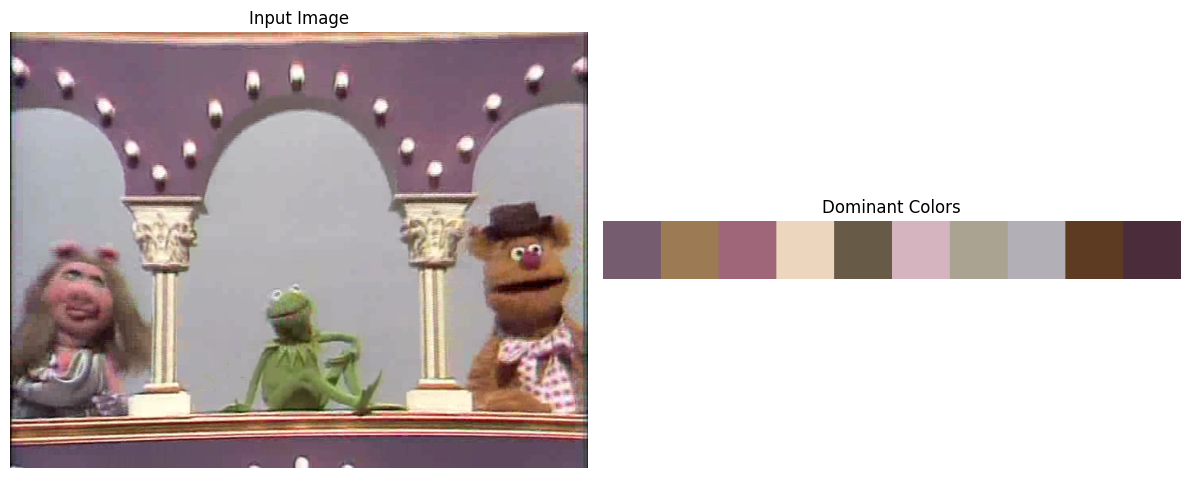

In [23]:
test_dominant_colors = extract_dominant_colors(test_img, 10, 10)
dominant_colors_bgr = cv2.cvtColor(np.uint8([test_dominant_colors]), cv2.COLOR_HSV2BGR)[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
color_bar = np.zeros((50, len(dominant_colors_bgr) * 50, 3), dtype=np.uint8)
for i, color in enumerate(dominant_colors_bgr):
    color_bar[:, i * 50:(i + 1) * 50] = color

plt.imshow(cv2.cvtColor(color_bar, cv2.COLOR_BGR2RGB))
plt.title("Dominant Colors")
plt.axis("off")
plt.tight_layout()
plt.show()

Code below allows to see the process dynamically in the video. 
Set `show_video = True` to run the code cell below for the visualisation. 
Note: the variable `n_clusters` must be changed within the loop for experiments, `n_colors` is not needed, it shows all colors by default (10 clusters = 10 colors).  

The code is slightly adapted from the top answer by u1234x1234 in this StackOverflow post https://stackoverflow.com/questions/73808864/get-most-dominant-colors-from-video-opencv-python. 

In [1]:
# Show video with color extraction
show_video = False

if show_video == True:
    cap = cv2.VideoCapture(vid_path)
    n_clusters = 10

    while True:
        status, image = cap.read()
        if not status:
            break

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        data = cv2.resize(hsv_image, (100, 100)).reshape(-1, 3)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
        compactness, labels, centers = cv2.kmeans(data.astype(np.float32), 10, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)  

        cluster_sizes = np.bincount(labels.flatten())

        palette = []
        for cluster_idx in np.argsort(-cluster_sizes):
            palette.append(np.full((image.shape[0], image.shape[1], 3), fill_value=centers[cluster_idx].astype(int), dtype=np.uint8))
        palette = np.hstack(palette)

        sf = image.shape[1] / palette.shape[1]
        out = np.vstack([image, cv2.resize(palette, (0, 0), fx=sf, fy=sf)])

        cv2.imshow("dominant_colors", out)
        cv2.waitKey(1)
else:
    print("Set show_video to True to play the video presentation")

Set show_video to True to play the video presentation


# Edge detection

In [ ]:
def extract_edges(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # apply Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)
    edge_features = edges.reshape(-1)

    return edge_features

# Object detection / removing background

In [4]:
vid_path = "../ground_truth_data/Muppets-02-01-01.avi"
frame_path = '../ground_truth_data/frames/Muppets-02-01-01_frame37500.png'

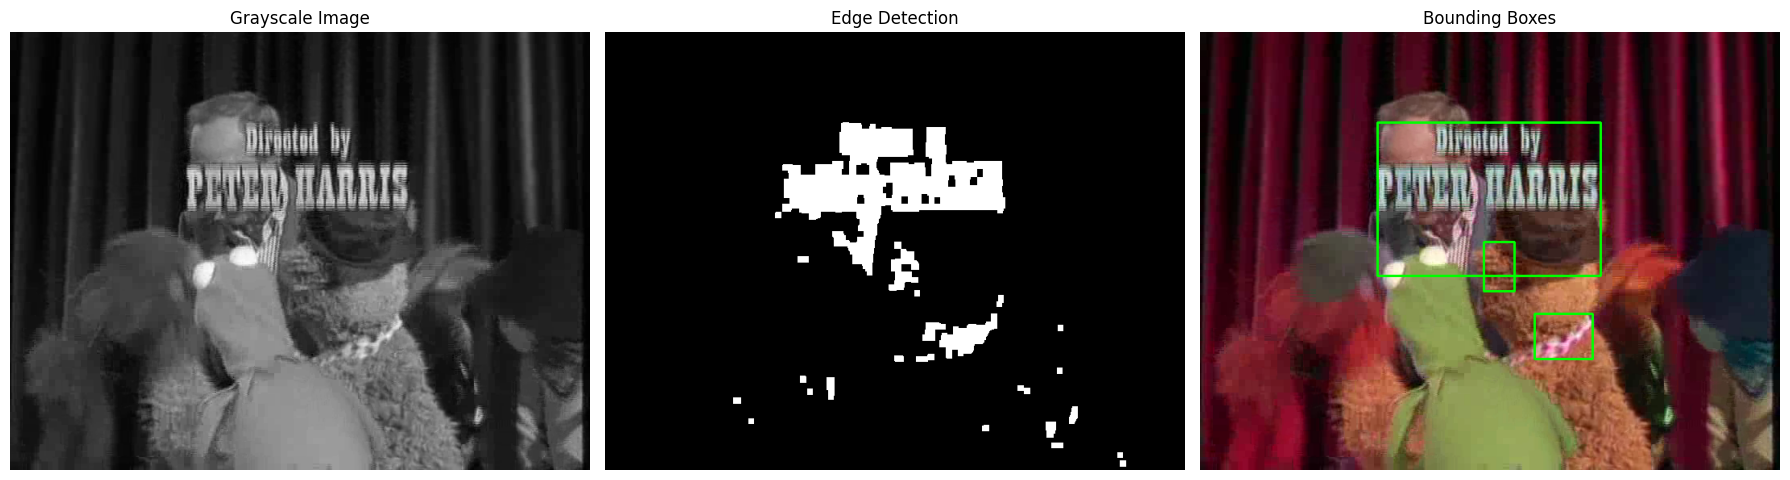

In [37]:
vid_path = "../ground_truth_data/Muppets-02-01-01.avi"

cap = cv2.VideoCapture(vid_path)
if not cap.isOpened():
    print("Error opening video file")
else:
    frame_number = 37500
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()

    if ret:
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply edge detection 
        edges = cv2.Canny(gray, 90, 200)  

        # Apply morphological operations with larger kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  # Larger kernel
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original frame
        frame_with_boxes = frame.copy()
        MIN_AREA = 500  # Lower minimum area threshold
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if cv2.contourArea(contour) > MIN_AREA: 
                cv2.rectangle(frame_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Convert BGR to RGB for Matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_with_boxes_rgb = cv2.cvtColor(frame_with_boxes, cv2.COLOR_BGR2RGB)

        # Display results using Matplotlib
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
        ax[0].set_title("Grayscale Image")
        ax[0].axis("off")

        ax[1].imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
        ax[1].set_title("Edge Detection")
        ax[1].axis("off")

        ax[2].imshow(frame_with_boxes_rgb)
        ax[2].set_title("Bounding Boxes")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Error reading frame {frame_number}")

cap.release()


In [ ]:
# Find contours
contours, hierarchy = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
frame_ct = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
# Display the resulting frame
cv2.imshow('Frame_final', frame_ct)

In [ ]:
retval, mask_thresh = cv2.threshold( fg_mask, 180, 255, cv2.THRESH_BINARY)

In [ ]:
# set the kernal
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# Apply erosion
mask_eroded = cv2.morphologyEx(mask_thresh, cv2.MORPH_OPEN, kernel)

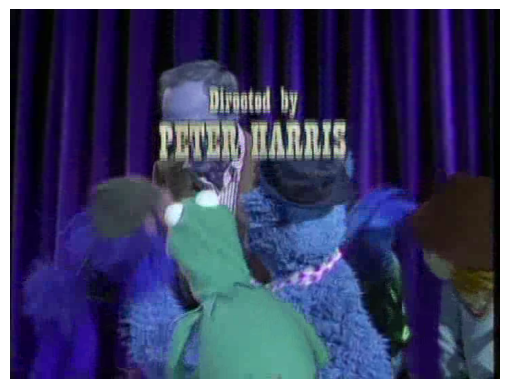

In [26]:
frame = cv2.imread('../ground_truth_data/frames/Muppets-02-01-01_frame37500.png')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [17]:
annotations['Muppets-02-01-01.avi'].loc[annotations['Muppets-02-01-01.avi']["Kermit"]==1]

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
970,211,970,1,0,0,0,0,0,0,0
971,211,971,1,0,0,0,0,0,0,0
972,211,972,1,0,0,0,0,0,0,0
973,211,973,1,0,0,0,0,0,0,0
974,211,974,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
37499,211,37499,1,0,0,0,0,0,0,0
37500,211,37500,1,0,0,0,0,0,0,0
37501,211,37501,1,0,0,0,0,0,0,0
37502,211,37502,1,0,0,0,0,0,0,0
